In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
%matplotlib inline

In [3]:
import tensorflow as tf
import re
import numpy as np
import tempfile
import os

import scipy.optimize as sopt

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [4]:
# From http://stackoverflow.com/questions/38189119/simple-way-to-visualize-a-tensorflow-graph-in-jupyter
# make things wide
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def=None, width=1200, height=800, max_const_size=32, ungroup_gradients=False):
    """Visualize TensorFlow graph."""
    if not graph_def:
        graph_def = tf.get_default_graph().as_graph_def()
        
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    data = str(strip_def)
    if ungroup_gradients:
        data = data.replace('"gradients/', '"b_')
        #print(data)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(data), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:{}px;height:{}px;border:0" srcdoc="{}"></iframe>
    """.format(width, height, code.replace('"', '&quot;'))
    display(HTML(iframe))

In [5]:
DATAURL = 'http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz'

In [6]:
TMPDIR = tempfile.mkdtemp()

In [7]:
!curl -o $TMPDIR/model.tgz $DATAURL
!tar zxvf $TMPDIR/model.tgz -C $TMPDIR
!ls $TMPDIR

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 84.8M  100 84.8M    0     0  94.2M      0 --:--:-- --:--:-- --:--:-- 94.1M
classify_image_graph_def.pb
cropped_panda.jpg
imagenet_2012_challenge_label_map_proto.pbtxt
imagenet_synset_to_human_label_map.txt
LICENSE
classify_image_graph_def.pb
cropped_panda.jpg
imagenet_2012_challenge_label_map_proto.pbtxt
imagenet_synset_to_human_label_map.txt
LICENSE
model.tgz


In [8]:
synset_to_class = {}
with open(os.path.join(TMPDIR, 'imagenet_synset_to_human_label_map.txt'), 'r') as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        synset, name = line.strip().split(None, 1)
        synset_to_class[synset] = name

output_to_class = {}
with open(os.path.join(TMPDIR, 'imagenet_2012_challenge_label_map_proto.pbtxt'), 'r') as f:
    last_target_class = None
    last_target_class_string = None
    for line in f:
        line = line.strip()
        if not line or not line.startswith('target_class'):
            continue
        
        key, val = line.strip().split(None, 1)
        
        if key == "target_class:":
            assert last_target_class is None
            last_target_class = int(val)
        else:
            assert key == "target_class_string:"
            assert val[0] == val[-1] == '"'
            assert last_target_class_string is None
            last_target_class_string = val[1:-1]
        if last_target_class is not None and last_target_class_string is not None:
            output_to_class[last_target_class] = synset_to_class[last_target_class_string]
            last_target_class = None
            last_target_class_string = None


In [9]:
output_to_class

{449: 'tench, Tinca tinca',
 450: 'goldfish, Carassius auratus',
 442: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 443: 'tiger shark, Galeocerdo cuvieri',
 444: 'hammerhead, hammerhead shark',
 445: 'electric ray, crampfish, numbfish, torpedo',
 446: 'stingray',
 383: 'cock',
 384: 'hen',
 385: 'ostrich, Struthio camelus',
 386: 'brambling, Fringilla montifringilla',
 387: 'goldfinch, Carduelis carduelis',
 388: 'house finch, linnet, Carpodacus mexicanus',
 389: 'junco, snowbird',
 390: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
 391: 'robin, American robin, Turdus migratorius',
 392: 'bulbul',
 393: 'jay',
 394: 'magpie',
 395: 'chickadee',
 396: 'water ouzel, dipper',
 397: 'kite',
 398: 'bald eagle, American eagle, Haliaeetus leucocephalus',
 399: 'vulture',
 400: 'great grey owl, great gray owl, Strix nebulosa',
 494: 'European fire salamander, Salamandra salamandra',
 495: 'common newt, Triturus vulgaris',
 496: 'eft'

In [10]:
tf.reset_default_graph()

In [11]:
with open(os.path.join(TMPDIR, 'classify_image_graph_def.pb'), 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    _ = tf.import_graph_def(graph_def, name='')
    
sess = tf.InteractiveSession()

In [ ]:
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = b"<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def=None, width=1200, height=800, max_const_size=32, ungroup_gradients=False):
    """Visualize TensorFlow graph."""
    if not graph_def:
        graph_def = tf.get_default_graph().as_graph_def()
        
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    data = str(strip_def)
    if ungroup_gradients:
        data = data.replace('"gradients/', '"b_')
        #print(data)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(data), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:{}px;height:{}px;border:0" srcdoc="{}"></iframe>
    """.format(width, height, code.replace('"', '&quot;'))
    display(HTML(iframe))

show_graph()

In [13]:
g = tf.get_default_graph()
[op.name for op in g.get_operations()]

['DecodeJpeg/contents',
 'DecodeJpeg',
 'Cast',
 'ExpandDims/dim',
 'ExpandDims',
 'ResizeBilinear/size',
 'ResizeBilinear',
 'Sub/y',
 'Sub',
 'Mul/y',
 'Mul',
 'conv/conv2d_params',
 'conv/Conv2D',
 'conv/batchnorm/beta',
 'conv/batchnorm/gamma',
 'conv/batchnorm/moving_mean',
 'conv/batchnorm/moving_variance',
 'conv/batchnorm',
 'conv/CheckNumerics',
 'conv/control_dependency',
 'conv',
 'conv_1/conv2d_params',
 'conv_1/Conv2D',
 'conv_1/batchnorm/beta',
 'conv_1/batchnorm/gamma',
 'conv_1/batchnorm/moving_mean',
 'conv_1/batchnorm/moving_variance',
 'conv_1/batchnorm',
 'conv_1/CheckNumerics',
 'conv_1/control_dependency',
 'conv_1',
 'conv_2/conv2d_params',
 'conv_2/Conv2D',
 'conv_2/batchnorm/beta',
 'conv_2/batchnorm/gamma',
 'conv_2/batchnorm/moving_mean',
 'conv_2/batchnorm/moving_variance',
 'conv_2/batchnorm',
 'conv_2/CheckNumerics',
 'conv_2/control_dependency',
 'conv_2',
 'pool/CheckNumerics',
 'pool/control_dependency',
 'pool',
 'conv_3/conv2d_params',
 'conv_3/Conv2D

In [14]:
unscaled_images = g.get_operation_by_name('Cast').outputs[0]
scaled_images = g.get_operation_by_name('ResizeBilinear').outputs[0]
predictions = g.get_operation_by_name('softmax').outputs[0]


In [15]:
unscaled_images

<tf.Tensor 'Cast:0' shape=(?, ?, 3) dtype=float32>

In [16]:
!curl -o $TMPDIR/image.jpg http://3.bp.blogspot.com/-VWEXN8U7UAE/UKvunmvcTmI/AAAAAAAABbQ/XWPi-0zb-4c/s320/rock_python1.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34577  100 34577    0     0   106k      0 --:--:-- --:--:-- --:--:--  106k


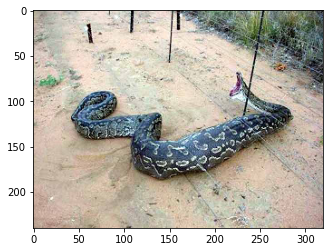

In [17]:
# im = mpimg.imread(os.path.join(TMPDIR, 'cropped_panda.jpg'))
im = mpimg.imread(os.path.join(TMPDIR, 'image.jpg'))
plt.imshow(im)
plt.grid(False)

In [18]:
predictions_v = sess.run(predictions, feed_dict={unscaled_images:im.astype('float32')})

In [19]:
top5 = np.argsort(predictions_v[0])[-5:][::-1]
for pred in top5:
    print ("%s: %f%%" % (output_to_class[pred], predictions_v[0, pred]))

rock python, rock snake, Python sebae: 0.688208%
boa constrictor, Constrictor constrictor: 0.066238%
king snake, kingsnake: 0.039305%
night snake, Hypsiglena torquata: 0.029993%
hognose snake, puff adder, sand viper: 0.015355%


# Visualize features

In [20]:
selected_layer = g.get_operation_by_name('mixed/join').outputs[0]
channel = 50
loss = - tf.reduce_sum(selected_layer[:,:,:, channel])

d_loss_d_scaled_images, = tf.gradients(loss, [scaled_images])
img_hist = []
def train_fun(img):
    img = img.reshape(scaled_images.shape.as_list()).astype('float32')
    img_hist.append(np.array(img[0]))
    loss_v, grad_v = sess.run([loss, d_loss_d_scaled_images], feed_dict={scaled_images: img})
    return loss_v, grad_v.ravel().astype('float64')

In [21]:
scaled_image_v = sess.run(scaled_images, feed_dict={unscaled_images:im.astype('float32')})

In [22]:
ret = sopt.fmin_l_bfgs_b(train_fun, np.random.rand(np.prod(scaled_image_v.shape)) + 128.,
                         bounds=[[0,255]]*np.prod(scaled_image_v.shape), iprint=1, maxiter=25)

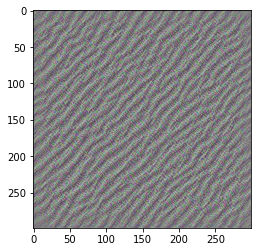

In [23]:
img = img_hist[-1]
plt.imshow((img - img.mean()) / max(img.std(), 1e-4)* 0.1 + 0.5)
plt.grid(False)

# Inceptionism

We will maximize the activations in a layer and see what patterns are picked up by the network.

Please note: a more complicated (and better) notebook is available at https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/deepdream/deepdream.ipynb
Also see the description at https://distill.pub/2017/feature-visualization/

In [24]:
scaled_image_v = sess.run(scaled_images, feed_dict={unscaled_images:im.astype('float32')})

In [25]:
scaled_image_v.shape

(1, 299, 299, 3)

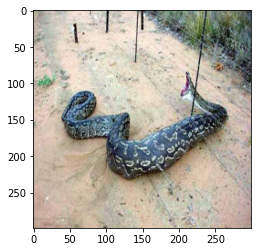

In [26]:
plt.imshow(scaled_image_v[0]/255.0)
plt.grid(False)

In [27]:
#selected_layer = g.get_operation_by_name('mixed_7/join').outputs[0]
#selected_layer = g.get_operation_by_name('conv_3').outputs[0]
selected_layer = g.get_operation_by_name('mixed/tower/conv_1').outputs[0] # closest to inceptionism
#selected_layer = g.get_operation_by_name('mixed_1/tower/conv_1').outputs[0]
#selected_layer = g.get_operation_by_name('mixed_10/tower_1/conv_1').outputs[0]
#loss = - tf.norm(selected_layer)
loss = - tf.reduce_sum(selected_layer)
d_loss_d_scaled_images, = tf.gradients(loss, [scaled_images])
img_hist = []
def train_fun(img):
    img = img.reshape(scaled_images.shape.as_list()).astype('float32')
    img_hist.append(np.array(img[0]))
    loss_v, grad_v = sess.run([loss, d_loss_d_scaled_images], feed_dict={scaled_images: img})
    return loss_v, grad_v.ravel().astype('float64')


In [28]:
ret = sopt.fmin_l_bfgs_b(train_fun, scaled_image_v.ravel().astype('float64'),
                         bounds=[[0,255]]*np.prod(scaled_image_v.shape), iprint=1, maxiter=50)

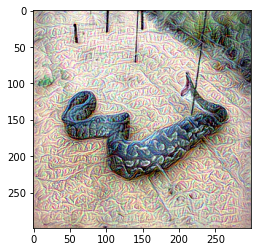

In [29]:
plt.imshow(img_hist[10]/255.)
plt.grid(False)

# Adversarial examples

It turns out one can slightly perturb an input image to dramatically change the network's output

In [30]:
predictions_v[0].argmax()

487

In [31]:
if 0:
    loss = tf.reduce_sum(predictions[:,predictions_v[0].argmax()]) # simply reduce prob of prediction
else:
    logits = g.get_operation_by_name('softmax/logits').outputs[0]
    loss = -tf.reduce_sum(logits[:, 150]) # optimize the weasel class
d_loss_d_scaled_images, = tf.gradients(loss, [scaled_images])
img_hist = []
def train_fun(img):
    img = img.reshape(scaled_images.shape.as_list()).astype('float32')
    img_hist.append(np.array(img[0]))
    loss_v, grad_v = sess.run([loss, d_loss_d_scaled_images], feed_dict={scaled_images: img})
    return loss_v, grad_v.ravel().astype('float64')

In [32]:
ret = sopt.fmin_l_bfgs_b(train_fun, scaled_image_v.ravel().astype('float64'),
                         bounds=[[0,255]]*np.prod(scaled_image_v.shape), iprint=1, maxiter=50)

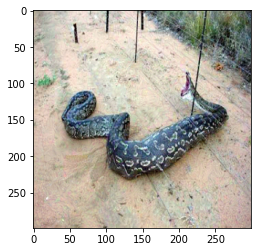

In [33]:
plt.imshow(img_hist[-1]/255.)
plt.grid(False)

'Brittany spaniel'

Brittany spaniel: 99.807823%
English setter: 0.165161%
English springer, English springer spaniel: 0.022750%
Welsh springer spaniel: 0.003749%
beagle: 0.000099%


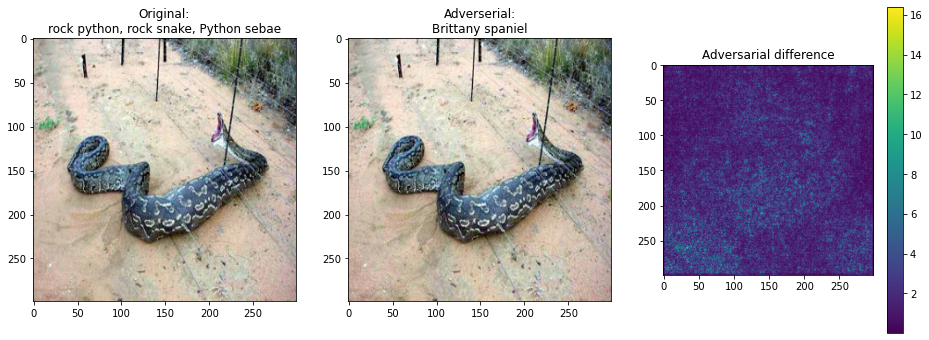

In [40]:
adv_iter=30

predictions_adverserial_v = sess.run(predictions, feed_dict={scaled_images:img_hist[adv_iter][None,...]})
top5 = np.argsort(predictions_adverserial_v[0])[-5:][::-1]
for pred in top5:
    print ("%s: %f%%" % (output_to_class[pred], predictions_adverserial_v[0, pred]*100))

plt.figure(figsize=(16,6))
plt.subplot(131)
plt.imshow(img_hist[0]/255.)
plt.grid(False)
plt.title(f'Original:\n{output_to_class[predictions_v[0].argmax()]}')

plt.subplot(132)
plt.imshow(img_hist[adv_iter]/255.)
plt.grid(False)
plt.title(f'Adverserial:\n{output_to_class[predictions_adverserial_v[0].argmax()]}')

plt.subplot(133)
plt.imshow(np.abs(img_hist[0] - img_hist[adv_iter]).mean(axis=-1))
plt.grid(False)
plt.title('Adversarial difference')
plt.colorbar()